In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from prophet.plot import plot_plotly
import joblib


In [1]:
df = pd.read_csv('Walmart_Sales.csv')
df.info()
print(df.nunique())
print(df.duplicated().sum()
)
df.head()


NameError: name 'pd' is not defined

# ✅ 1. Data Cleaning & Preprocessing
* Parse Date into datetime and extract features: month, year, week, is_weekend, season
<!-- * Normalize continuous variables (CPI, Fuel_Price, Temperature) -->
* Encode Holiday_Flag as binary or category
* Detect and handle outliers in Weekly_Sales (e.g., spikes during Black Friday)

In [ ]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Extract features
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day
df['Is_Weekend'] = df['Date'].dt.weekday >= 5  # Saturday or Sunday

# Optional: Define Season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Year,Week,Day,Is_Weekend,Season
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010,5,5,False,Winter
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010,6,12,False,Winter
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010,7,19,False,Winter
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010,8,26,False,Winter
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010,9,5,False,Spring


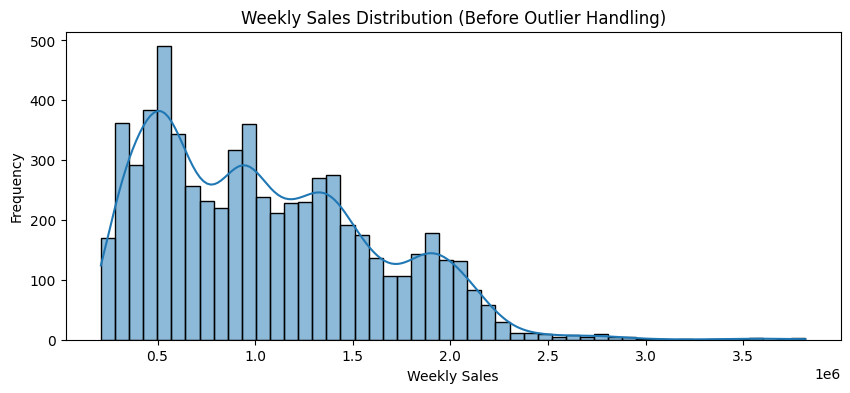

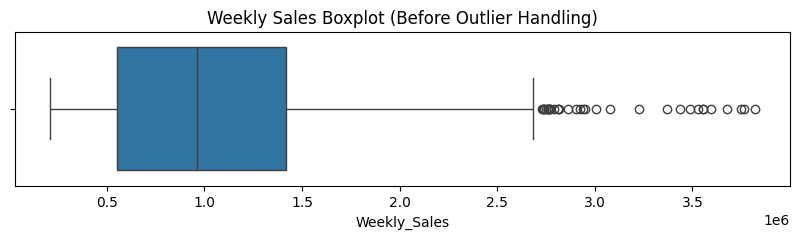

In [ ]:

# Histogram
fig1 = px.histogram(df, x='Weekly_Sales', nbins=50, title='Weekly Sales Distribution (Before Outlier Handling)')
fig1.update_layout(bargap=0.1)
fig1.show()

# Boxplot
fig2 = px.box(df, y='Weekly_Sales', title='Weekly Sales Boxplot (Before Outlier Handling)')
fig2.show()

# Histogram
plt.figure(figsize=(10, 4))
sns.histplot(df['Weekly_Sales'], bins=50, kde=True)
plt.title('Weekly Sales Distribution (Before Outlier Handling)')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.figure(figsize=(10, 2))
sns.boxplot(x=df['Weekly_Sales'])
plt.title('Weekly Sales Boxplot (Before Outlier Handling)')
plt.show()


High Sales Periods: 34 weeks (0.53%)
              Normal_Sales  High_Sales
Temperature      60.772042   40.282353
Fuel_Price        3.359634    3.165206
CPI             171.642219  159.562420
Unemployment      8.002298    7.406765
Holiday_Flag      0.068895    0.264706


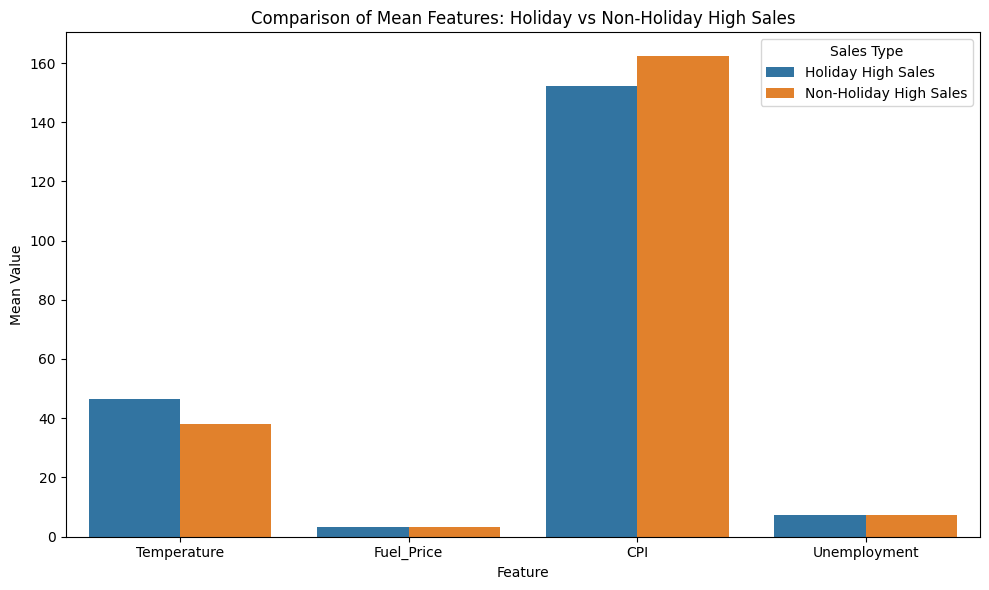

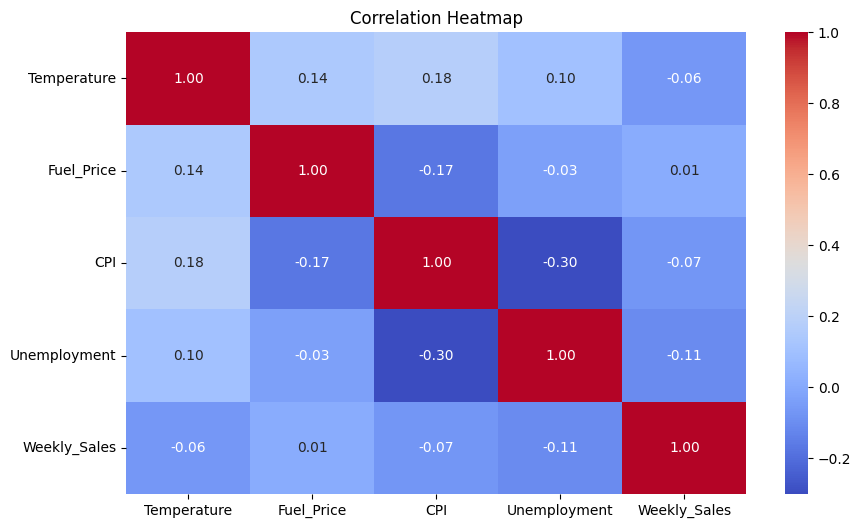

In [ ]:
# Explore Outliers
# Calculate IQR
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

upper_fence = Q3 + 1.5 * IQR
lower_fence = Q1 - 1.5 * IQR

# Use upper fence from IQR to define high sales periods
df['High_Sales'] = df['Weekly_Sales'] >= upper_fence

# Check how many weeks qualify
print(f"High Sales Periods: {df['High_Sales'].sum()} weeks ({df['High_Sales'].mean() * 100:.2f}%)")

features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag']

features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag']

# Group by High_Sales flag and compute average values
comparison = df.groupby('High_Sales')[features].mean().T
comparison.columns = ['Normal_Sales', 'High_Sales']
print(comparison)

import plotly.graph_objects as go

fig = go.Figure()

for feature in features:
    fig.add_trace(go.Bar(
        name=feature,
        x=['Normal Sales', 'High Sales'],
        y=[
            df[df['High_Sales'] == False][feature].mean(),
            df[df['High_Sales'] == True][feature].mean()
        ]
    ))

fig.update_layout(
    title='Feature Comparison: High Sales (Boxplot Upper Fence) vs Normal Sales (with Holiday)',
    barmode='group'
)
fig.show()


# Seaborn Visualization
high_sales = df[df['High_Sales'] == True]

# Split into holiday and non-holiday high sales
holiday_high_sales = high_sales[high_sales['Holiday_Flag'] == 1]
nonholiday_high_sales = high_sales[high_sales['Holiday_Flag'] == 0]
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
holiday_means = holiday_high_sales[features].mean()
nonholiday_means = nonholiday_high_sales[features].mean()

# Prepare DataFrame for seaborn
comparison_df = pd.DataFrame({
    'Feature': features * 2,
    'Mean Value': list(holiday_means) + list(nonholiday_means),
    'Type': ['Holiday High Sales'] * len(features) + ['Non-Holiday High Sales'] * len(features)
})

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x='Feature', y='Mean Value', hue='Type')
plt.title('Comparison of Mean Features: Holiday vs Non-Holiday High Sales')
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.legend(title='Sales Type')
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[features + ['Weekly_Sales']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()






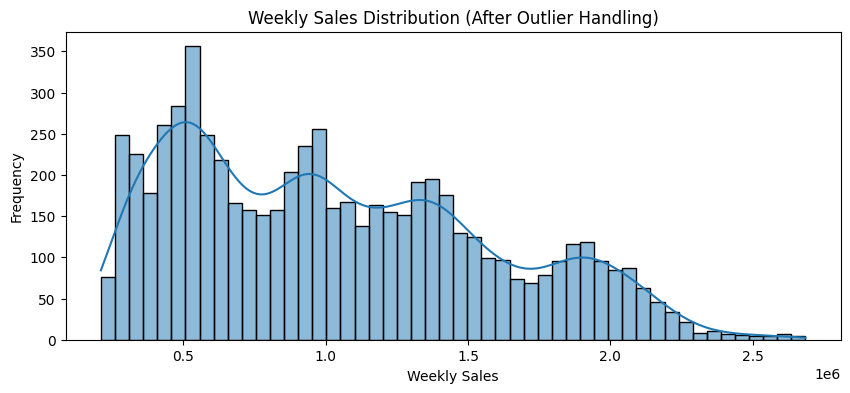

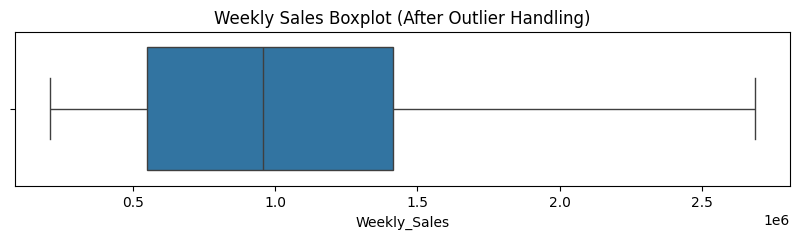

In [ ]:
# Handle Outliers
outliers_df = df[df['Weekly_Sales'] > upper_fence]
# Remove outliers from the main DataFrame
df = df[df['Weekly_Sales'] <= upper_fence]
# Histogram after removing outliers
fig3 = px.histogram(df, x='Weekly_Sales', nbins=50, title='Weekly Sales Distribution (After Outlier Handling)')
fig3.update_layout(bargap=0.1)
fig3.show()

# Boxplot after removing outliers
fig4 = px.box(df, y='Weekly_Sales', title='Weekly Sales Boxplot (After Outlier Handling)')
fig4.show()
# Histogram after removing outliers
plt.figure(figsize=(10, 4))
sns.histplot(df['Weekly_Sales'], bins=50, kde=True)
plt.title('Weekly Sales Distribution (After Outlier Handling)')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()
# Boxplot after removing outliers
plt.figure(figsize=(10, 2))
sns.boxplot(x=df['Weekly_Sales'])
plt.title('Weekly Sales Boxplot (After Outlier Handling)')
plt.show()
# Save the cleaned DataFrame


# 📊 Phase 2: Exploratory Data Analysis (EDA)
🔢 Sales Patterns
* Total weekly sales per store
* Compare sales during holiday vs non-holiday weeks
* Store-wise comparison: top-performing vs low-performing stores
* Heatmap or time series of sales trends over time

📈 Correlation Analysis
* Correlation matrix: Sales vs Temperature, CPI, Unemployment, Fuel Price
* Does low fuel price = higher sales?
* Impact of temperature extremes on sales

📅 Seasonality
* Line plots to show sales patterns across seasons (e.g., holidays, summer)
* Detect annual cyclic patterns using time series decomposition


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6401 entries, 0 to 6434
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6401 non-null   int64         
 1   Date          6401 non-null   datetime64[ns]
 2   Weekly_Sales  6401 non-null   float64       
 3   Holiday_Flag  6401 non-null   int64         
 4   Temperature   6401 non-null   float64       
 5   Fuel_Price    6401 non-null   float64       
 6   CPI           6401 non-null   float64       
 7   Unemployment  6401 non-null   float64       
 8   Month         6401 non-null   int32         
 9   Year          6401 non-null   int32         
 10  Week          6401 non-null   UInt32        
 11  Day           6401 non-null   int32         
 12  Is_Weekend    6401 non-null   bool          
 13  Season        6401 non-null   object        
 14  High_Sales    6401 non-null   bool          
dtypes: UInt32(1), bool(2), datetime64[ns](1), f

### 🔢 Sales Patterns

In [ ]:
# Total weekly sales per store
total_sales_store = df.groupby('Store')['Weekly_Sales'].sum().reset_index()
total_sales_store = total_sales_store.sort_values(by='Weekly_Sales', ascending=False)
fig2 = px.bar(total_sales_store, x='Store', y='Weekly_Sales',
              title='Total Weekly Sales per Store',
              labels={'Weekly_Sales': 'Total Weekly Sales ($)'})
fig2.show()

# Compare sales during holidays vs non-holidays for each store
holiday_sales = df[df['Holiday_Flag'] == 1].groupby('Store')['Weekly_Sales'].mean().reset_index()
non_holiday_sales = df[df['Holiday_Flag'] == 0].groupby('Store')['Weekly_Sales'].mean().reset_index()
holiday_sales = holiday_sales.rename(columns={'Weekly_Sales': 'Holiday_Sales'})
non_holiday_sales = non_holiday_sales.rename(columns={'Weekly_Sales': 'Non_Holiday_Sales'})
comparison_sales = pd.merge(holiday_sales, non_holiday_sales, on='Store')
comparison_sales['Sales_Difference'] = comparison_sales['Holiday_Sales'] - comparison_sales['Non_Holiday_Sales']
fig3 = px.bar(comparison_sales, x='Store', y=['Holiday_Sales', 'Non_Holiday_Sales'],
              title='Holiday vs Non-Holiday Sales per Store',
              labels={'value': 'Weekly Sales ($)', 'variable': 'Sales Type'})
fig3.update_layout(barmode='group')
fig3.show()


In [ ]:
# Store-wise comparison: top-performing vs low-performing stores
avg_sales_store = df.groupby('Store')['Weekly_Sales'].mean().reset_index()
avg_sales_store = avg_sales_store.sort_values(by='Weekly_Sales', ascending=False)

# Top and bottom 5 stores
top_5 = avg_sales_store.head(5).copy()
top_5['Performance'] = 'Top'

bottom_5 = avg_sales_store.tail(5).copy()
bottom_5['Performance'] = 'Bottom'
combined_df = pd.concat([top_5, bottom_5])
fig = px.bar(combined_df, x='Store', y='Weekly_Sales', color='Performance',
             title='Top 5 vs Bottom 5 Performing Stores',
             labels={'Weekly_Sales': 'Avg Weekly Sales ($)', 'Store': 'Store ID'})
fig.show()




In [ ]:
df_trend = df.groupby('Date')['Weekly_Sales'].mean().reset_index()

fig4 = px.line(df_trend, x='Date', y='Weekly_Sales',
               title='Total Weekly Sales Over Time',
               labels={'Weekly_Sales': 'Total Weekly Sales ($)', 'Date': 'Week'})
fig4.show()


In [ ]:
# Heatmap of total sales by store and month
# Aggregate sale
monthly_sales = df.groupby(['Store', 'Month'])['Weekly_Sales'].sum().reset_index()

# Pivot for heatmap
heatmap_data = monthly_sales.pivot(index='Store', columns='Month', values='Weekly_Sales')

# Sort month columns by calendar order
heatmap_data.columns = [calendar.month_abbr[m] for m in heatmap_data.columns]

fig5 = px.imshow(
    heatmap_data,
    labels=dict(x="Month", y="Store", color="Total Sales"),
    x=heatmap_data.columns,
    y=heatmap_data.index,
    color_continuous_scale="Viridis",
    title="Heatmap of Total Sales by Store and Month"
)
fig5.show()

# Group by Store and Week
weekly_sales = df.groupby(['Store', 'Week'])['Weekly_Sales'].sum().reset_index()
# Pivot table for heatmap
heatmap_week = weekly_sales.pivot(index='Store', columns='Week', values='Weekly_Sales')

fig6 = px.imshow(
    heatmap_week,
    labels=dict(x="Week Number", y="Store", color="Total Sales"),
    x=heatmap_week.columns,
    y=heatmap_week.index,
    color_continuous_scale="Plasma",
    title="Store vs. Week Number: Heatmap of Weekly Sales"
)

fig6.update_layout(height=600)
fig6.show()


In [ ]:
fig = px.line(df, x='Date', y='Weekly_Sales', color='Store', title='Weekly Sales Trend by Store')
fig.show()


### 📈 Correlation Analysis


In [ ]:
import plotly.figure_factory as ff

correlation_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
corr_matrix = df[correlation_features].corr()

fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=correlation_features,
    y=correlation_features,
    colorscale='Viridis',
    showscale=True
)
fig.update_layout(title="Correlation Matrix - Sales vs Other Features")
fig.show()


In [ ]:
#3. Impact of Temperature on Sales 
fig = px.scatter(
    df, x='Temperature', y='Weekly_Sales',
    color='Holiday_Flag',  # to see if there's a holiday effect too
    title='Sales vs Temperature Extremes',
    labels={'Temperature': 'Temperature (°F)', 'Weekly_Sales': 'Weekly Sales'}
)
fig.show()

# Impact of Fuel Price on Sales
fig = px.scatter(
    df, x='Fuel_Price', y='Weekly_Sales',
    color='Holiday_Flag',  # to see if there's a holiday effect too
    title='Sales vs Fuel Price',
    labels={'Fuel_Price': 'Fuel Price ($)', 'Weekly_Sales': 'Weekly Sales'}
)
fig.show()

# Impact of CPI on Sales
fig = px.scatter(
    df, x='CPI', y='Weekly_Sales',
    color='Holiday_Flag',  # to see if there's a holiday effect too
    title='Sales vs CPI',
    labels={'CPI': 'CPI Index', 'Weekly_Sales': 'Weekly Sales'}
)
fig.show()

# Impact of Unemployment on Sales
fig = px.scatter(
    df, x='Unemployment', y='Weekly_Sales',
    color='Holiday_Flag',  # to see if there's a holiday effect too
    title='Sales vs Unemployment Rate',
    labels={'Unemployment': 'Unemployment Rate (%)', 'Weekly_Sales': 'Weekly Sales'}
)
fig.show()


### 📅 Seasonality Analysis


In [ ]:
fig = px.box(
    df, x='Season', y='Weekly_Sales',
    title='Sales Distribution by Season',
    color='Season',
    labels={'Weekly_Sales': 'Weekly Sales'}
)
fig.show()


In [ ]:
monthly_sales = df.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()
monthly_sales['Month_Year'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(DAY=1))

fig = px.line(monthly_sales, x='Month_Year', y='Weekly_Sales',
              title='Monthly Sales Trend Over Time',
              labels={'Month_Year': 'Month-Year', 'Weekly_Sales': 'Total Sales'})
fig.update_xaxes(dtick="M1", tickformat="%b\n%Y")
fig.show()


In [ ]:
df_sorted = df.sort_values('Date')

fig = px.line(
    df_sorted, x='Date', y='Weekly_Sales',
    color='Season',
    title='Weekly Sales Over Time by Season',
    labels={'Weekly_Sales': 'Weekly Sales'}
)
fig.show()

In [ ]:
# Weekly Sales Patterns Across Seasons
fig = px.line(df, x='Week', y='Weekly_Sales', color='Season',
              title='Weekly Sales Patterns Across Seasons',
              labels={'Week': 'Week Number', 'Weekly_Sales': 'Total Weekly Sales'})
fig.update_layout(legend_title='Season')
fig.show()

In [ ]:
# Calculate 4-week moving average for Weekly Sales
df = df.sort_values(by=['Year', 'Week'])  # Ensure data is sorted by time
df['Weekly_Sales_MA'] = df['Weekly_Sales'].rolling(window=4).mean()


In [ ]:
# Create a line plot with moving average
fig = px.line(df, x='Week', y='Weekly_Sales', color='Season',
              title='Weekly Sales Patterns Across Seasons (with 4-Week Moving Average)',
              labels={'Week': 'Week Number', 'Weekly_Sales': 'Total Weekly Sales'})

# # Add moving average line for each season
# for season in df['Season'].unique():
#     df_season = df[df['Season'] == season]
#     fig.add_scatter(x=df_season['Week'], y=df_season['Weekly_Sales_MA'],
#                     mode='lines', name=f'{season} MA (4W)')

fig.update_layout(legend_title='Season')
fig.show()


# 🤖 3. Predictive Modeling with Machine Learning
Frame this as a regression task: Predict Weekly_Sales
ML Models:
* Baseline: Linear Regression
* Tree-based models: Random Forest Regressor, XGBoost
* Optional: Time-series models (e.g., SARIMAX, Prophet)
Features to use:
* Store
* Week/Month/Season
* Holiday_Flag
* CPI
* Unemployment
* Temperature
* Fuel_Price
Metrics:
* RMSE, MAE, R²
Explainability:
* Use SHAP or Feature Importance to explain what factors drive predictions
* "Which economic factor has the greatest effect on sales?"

In [ ]:
df.info()

# Dictionary to store results
model_results = {}

<class 'pandas.core.frame.DataFrame'>
Index: 6401 entries, 0 to 6434
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Store            6401 non-null   int64         
 1   Date             6401 non-null   datetime64[ns]
 2   Weekly_Sales     6401 non-null   float64       
 3   Holiday_Flag     6401 non-null   int64         
 4   Temperature      6401 non-null   float64       
 5   Fuel_Price       6401 non-null   float64       
 6   CPI              6401 non-null   float64       
 7   Unemployment     6401 non-null   float64       
 8   Month            6401 non-null   int32         
 9   Year             6401 non-null   int32         
 10  Week             6401 non-null   UInt32        
 11  Day              6401 non-null   int32         
 12  Is_Weekend       6401 non-null   bool          
 13  Season           6401 non-null   object        
 14  High_Sales       6401 non-null   bool        

In [ ]:

# Select features and target
features = ['Store', 'Week', 'Month', 'Season', 'Holiday_Flag', 'CPI', 'Unemployment', 'Temperature', 'Fuel_Price']
X = df[features]
y = df['Weekly_Sales']

# Encode Season (categorical)
X = pd.get_dummies(X, columns=['Season'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling (especially useful for linear models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Evaluation
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

# Store result
model_results['Linear Regression'] = {
    'MAE': lr_mae,
    'RMSE': lr_rmse,
    'R2': lr_r2
}

# Print result
print("📊 Linear Regression Performance:")
print(f"  MAE:  {lr_mae:.2f}")
print(f"  RMSE: {lr_rmse:.2f}")
print(f"  R²:   {lr_r2:.4f}")


📊 Linear Regression Performance:
  MAE:  418383.63
  RMSE: 502820.53
  R²:   0.1670


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Evaluation
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

# Store result
model_results['Random Forest'] = {
    'MAE': rf_mae,
    'RMSE': rf_rmse,
    'R2': rf_r2
}

# Print result
print("🌲 Random Forest Performance:")
print(f"  MAE:  {rf_mae:.2f}")
print(f"  RMSE: {rf_rmse:.2f}")
print(f"  R²:   {rf_r2:.4f}")


🌲 Random Forest Performance:
  MAE:  62976.37
  RMSE: 105710.14
  R²:   0.9632


In [ ]:
from xgboost import XGBRegressor

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Evaluation
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

# Store result
model_results['XGBoost'] = {
    'MAE': xgb_mae,
    'RMSE': xgb_rmse,
    'R2': xgb_r2
}

# Print result
print("⚡ XGBoost Performance:")
print(f"  MAE:  {xgb_mae:.2f}")
print(f"  RMSE: {xgb_rmse:.2f}")
print(f"  R²:   {xgb_r2:.4f}")


⚡ XGBoost Performance:
  MAE:  47630.04
  RMSE: 85913.90
  R²:   0.9757


In [ ]:
import pandas as pd

# Step 1: Generate 10 future weekly dates
last_date = df['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=10, freq='W')

future_df = pd.DataFrame({'Date': future_dates})


# Extract date-based features
future_df['Month'] = future_df['Date'].dt.month
future_df['Year'] = future_df['Date'].dt.year
future_df['Week'] = future_df['Date'].dt.isocalendar().week
future_df['Day'] = future_df['Date'].dt.day
future_df['Is_Weekend'] = future_df['Date'].dt.weekday >= 5

# Assign default values for static features
future_df['Holiday_Flag'] = 0  # assume no holiday
future_df['Temperature'] = df['Temperature'].mean()
future_df['Fuel_Price'] = df['Fuel_Price'].mean()
future_df['CPI'] = df['CPI'].mean()
future_df['Unemployment'] = df['Unemployment'].mean()

# Assign most frequent Season
mode_season = df['Season'].mode()[0]
future_df['Season'] = mode_season

# If you used one-hot encoding or LabelEncoder, do the same here:
future_df = pd.get_dummies(future_df, columns=['Season'], drop_first=True)

# Match training columns (adjust if needed)
missing_cols = set(X_train.columns) - set(future_df.columns)
for col in missing_cols:
    future_df[col] = 0  # add missing columns with 0

future_df = future_df[X_train.columns]  # reorder columns


# Make predictions
future_preds = xgb_model.predict(future_df)

# Combine with dates
forecast = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Weekly_Sales': future_preds
})

print(forecast)


        Date  Predicted_Weekly_Sales
0 2012-11-04             1993257.250
1 2012-11-11             1993257.250
2 2012-11-18             1965029.375
3 2012-11-25             2274711.750
4 2012-12-02             2132837.750
5 2012-12-09             2416411.500
6 2012-12-16             1901429.875
7 2012-12-23             2141329.000
8 2012-12-30             1572602.750
9 2013-01-06             1708191.500


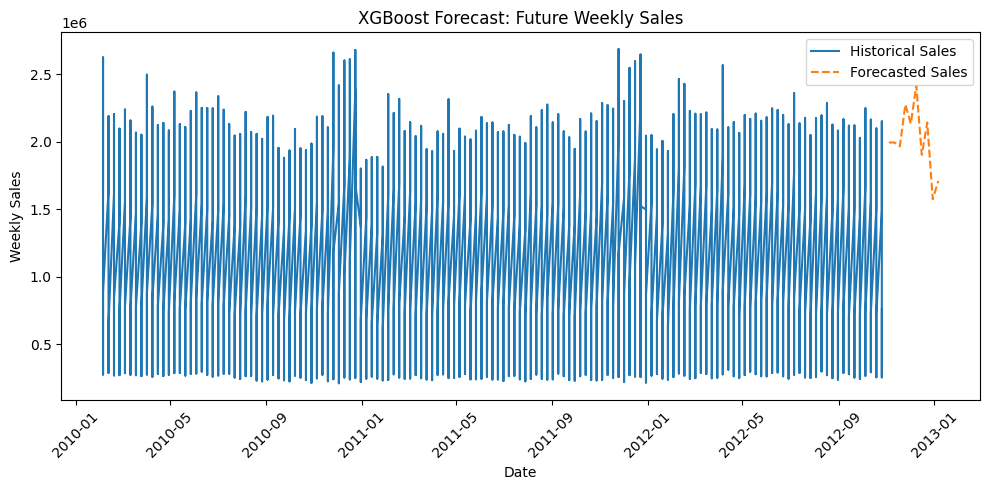

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Weekly_Sales'], label='Historical Sales')
plt.plot(forecast['Date'], forecast['Predicted_Weekly_Sales'], label='Forecasted Sales', linestyle='--')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('XGBoost Forecast: Future Weekly Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
print(forecast.columns)
print(df.columns)


Index(['Date', 'Predicted_Weekly_Sales'], dtype='object')
Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Month', 'Year', 'Week', 'Day',
       'Is_Weekend', 'Season', 'High_Sales', 'Weekly_Sales_MA'],
      dtype='object')


In [ ]:
import plotly.graph_objects as go

# Actual historical data
historical_df = df[['Date', 'Weekly_Sales']].copy()

# Plotly figure
fig = go.Figure()

# Add historical sales
fig.add_trace(go.Scatter(
    x=historical_df['Date'],
    y=historical_df['Weekly_Sales'],
    mode='lines+markers',
    name='Historical Sales',
    line=dict(color='blue')
))

# Add XGBoost predictions
fig.add_trace(go.Scatter(
    x=forecast['Date'],
    y=forecast['Predicted_Weekly_Sales'],
    mode='lines+markers',
    name='XGBoost Forecast',
    line=dict(color='green', dash='dash')
))

# Update layout
fig.update_layout(
    title='XGBoost Sales Forecast (Next 10 Weeks)',
    xaxis_title='Date',
    yaxis_title='Weekly Sales',
    hovermode='x unified',
    template='plotly_white'
)

# Show plot
fig.show()


In [ ]:
# Save to file
joblib.dump(xgb_model, "xgb_model.pkl")

['xgb_model.pkl']

In [ ]:
# STEP 1: Import & prepare data for Prophet
from prophet import Prophet


# Aggregate weekly sales (total across all stores)
df_prophet = df.groupby('Date').agg({'Weekly_Sales': 'sum'}).reset_index()

# Rename columns as required by Prophet
df_prophet.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}, inplace=True)

# Preview
df_prophet.head()


,ds,y
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30


In [ ]:
# Sort by date
df_prophet = df_prophet.sort_values("ds")

# Let's use last 10 weeks as test
train = df_prophet[:-10]
test = df_prophet[-10:]


# Initialize Prophet
prophet_model = Prophet()

# Fit model
prophet_model.fit(train)


# Create future dataframe for prediction
future = prophet_model.make_future_dataframe(periods=10, freq='W')  # predict 10 weeks ahead

# Make predictions
forecast = prophet_model.predict(future)

# View forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)


# Merge forecast with actual test values
merged = forecast[['ds', 'yhat']].merge(test, on='ds', how='inner')

# Evaluate
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))

print(f"📉 Prophet Performance:")
print(f"  MAE:  {mae:,.2f}")
print(f"  RMSE: {rmse:,.2f}")


# Plot with Plotly (interactive)
fig = plot_plotly(prophet_model, forecast)
fig.show()


In [ ]:
# STEP 2: Initialize & fit Prophet
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(df_prophet)


# STEP 3: Create future dates
future = model.make_future_dataframe(periods=12, freq='W')  # predict 12 future weeks

# Make predictions
forecast = model.predict(future)

# Show forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)


16:58:44 - cmdstanpy - INFO - Chain [1] start processing
16:58:44 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
143,2012-10-28,4.915573e+07,4.705959e+07,5.118190e+07
144,2012-11-04,4.967566e+07,4.732015e+07,5.194656e+07
145,2012-11-11,5.093647e+07,4.889949e+07,5.311261e+07
146,2012-11-18,5.278871e+07,5.059164e+07,5.492566e+07
147,2012-11-25,5.470051e+07,5.261659e+07,5.698293e+07
148,2012-12-02,5.610673e+07,5.400932e+07,5.834108e+07
149,2012-12-09,5.659603e+07,5.447983e+07,5.886289e+07
150,2012-12-16,5.586149e+07,5.379454e+07,5.821698e+07
151,2012-12-23,5.372104e+07,5.157479e+07,5.593632e+07
152,2012-12-30,5.042039e+07,4.823099e+07,5.253193e+07


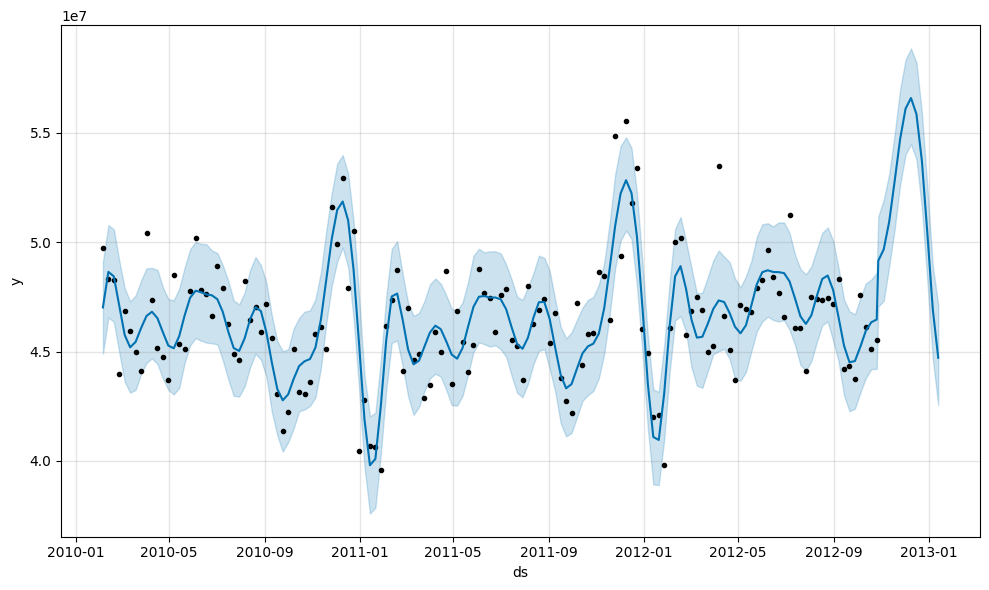

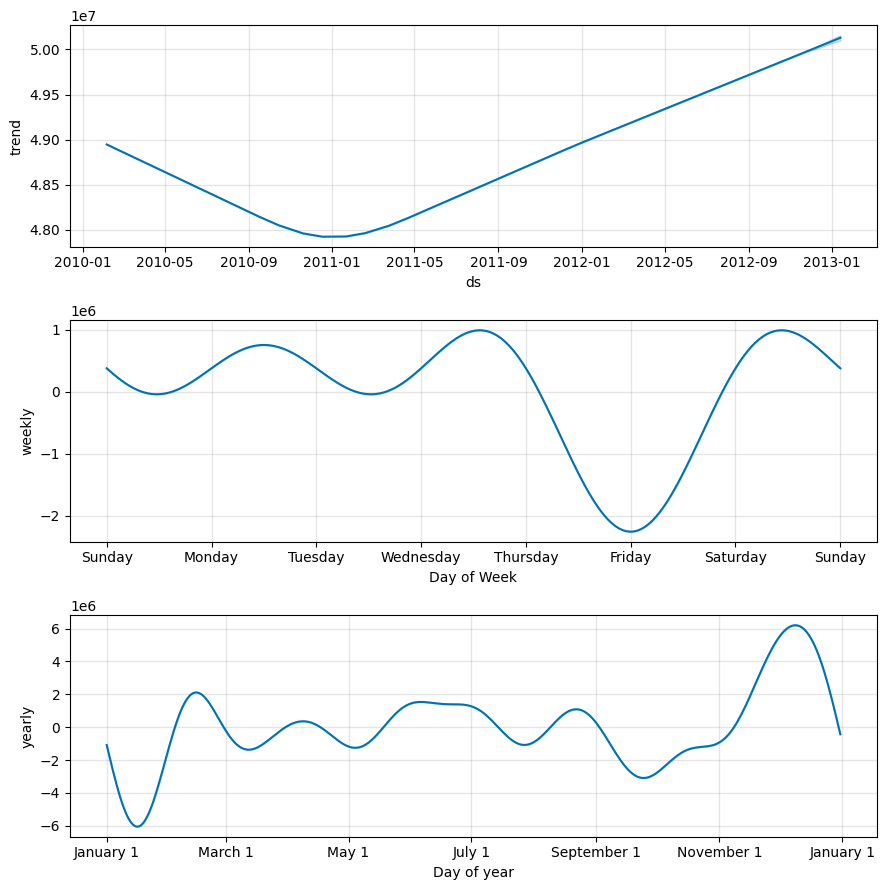

In [ ]:
# STEP 4: Visualize forecast
model.plot(forecast);
model.plot_components(forecast);


In [ ]:
import plotly.graph_objects as go

# Prophet forecast visualization
fig = go.Figure()

# Forecast line
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat'],
    mode='lines', name='Forecast', line=dict(color='blue')
))

# Uncertainty interval (shaded)
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_upper'],
    mode='lines', name='Upper Bound', line=dict(width=0),
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat_lower'],
    mode='lines', name='Lower Bound', fill='tonexty', line=dict(width=0),
    fillcolor='rgba(135, 206, 250, 0.3)', showlegend=True
))

fig.update_layout(
    title='📈 Prophet Forecast of Weekly Sales (with Confidence Interval)',
    xaxis_title='Date',
    yaxis_title='Predicted Weekly Sales',
    template='plotly_white',
    hovermode='x unified'
)

fig.show()


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')


weekly_df = df.groupby('Date').agg({'Weekly_Sales': 'sum',
                                     'Temperature': 'mean',
                                     'Fuel_Price': 'mean',
                                     'CPI': 'mean',
                                     'Unemployment': 'mean',
                                     'Holiday_Flag': 'max',
                                     'Season': lambda x: x.mode()[0]}).reset_index()


weekly_df['Month'] = weekly_df['Date'].dt.month
weekly_df['Year'] = weekly_df['Date'].dt.year
weekly_df['Week'] = weekly_df['Date'].dt.isocalendar().week
weekly_df['Day'] = weekly_df['Date'].dt.day
weekly_df['Is_Weekend'] = weekly_df['Date'].dt.weekday >= 5

# One-hot encode Season
weekly_df = pd.get_dummies(weekly_df, columns=['Season'], drop_first=True)


# Sort again to be safe
weekly_df = weekly_df.sort_values('Date')

# Create feature set and target
X = weekly_df.drop(['Weekly_Sales', 'Date'], axis=1)
y = weekly_df['Weekly_Sales']

# Time-based split
split_index = int(len(weekly_df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
dates_test = weekly_df['Date'].iloc[split_index:]  # needed later


In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Combine with dates
xgb_results = pd.DataFrame({
    'Date': dates_test.values,
    'Actual': y_test.values,
    'XGBoost_Predicted': y_pred_xgb
})


In [ ]:
df_prophet = weekly_df[['Date', 'Weekly_Sales']].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

df_train_p = df_prophet.iloc[:split_index]
df_test_p = df_prophet.iloc[split_index:]

model = Prophet()
model.fit(df_train_p)

# Forecast over the test period
future = df_test_p[['ds']].copy()
forecast = model.predict(future)

# Merge actuals with forecast
prophet_results = df_test_p.copy()
prophet_results['Prophet_Predicted'] = forecast['yhat'].values

comparison = pd.merge(xgb_results, prophet_results[['ds', 'Prophet_Predicted']],
                      left_on='Date', right_on='ds', how='inner').drop(columns='ds')



16:58:51 - cmdstanpy - INFO - Chain [1] start processing
16:58:51 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
fig = px.line(comparison, x='Date', y=['Actual', 'XGBoost_Predicted', 'Prophet_Predicted'],
              title='Sales Forecast: XGBoost vs Prophet',
              labels={'value': 'Weekly Sales', 'variable': 'Model'})
fig.show()


In [ ]:
from sklearn.metrics import mean_absolute_error

mae_xgb = mean_absolute_error(comparison['Actual'], comparison['XGBoost_Predicted'])
mae_prophet = mean_absolute_error(comparison['Actual'], comparison['Prophet_Predicted'])

print(f"MAE - XGBoost: {mae_xgb:,.2f}")
print(f"MAE - Prophet: {mae_prophet:,.2f}")



MAE - XGBoost: 4,132,684.35
MAE - Prophet: 1,953,917.96
